# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---


---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. 
![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.
### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:


* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [2]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 2


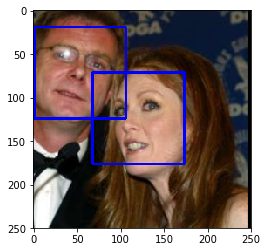

In [25]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[42])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

###  Assess the Human Face Detector

  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

There are 98.0% detected human face of the first 100 images in human_files .

There are 17.0% detected human face of the first 100 images in dog_files .

In [13]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]


detected_human = 0
detected_dog = 0
for human in human_files_short:
    detected_human += face_detector(human)
for dog in dog_files_short:
    detected_dog += face_detector(dog)
    
human_percentage = 100 * (detected_human /len(human_files_short))
dog_percentage = 100 * (detected_dog /len(dog_files_short))
print('There are %.d%% detected human face of the first 100 images in human_files .' % human_percentage)
print('There are %.d%% detected human face of the first 100 images in dog_files .' % dog_percentage)



There are 98% detected human face of the first 100 images in human_files .
There are 17% detected human face of the first 100 images in dog_files .


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [4]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [22:33<00:00, 408760.68it/s]  


In [6]:
print(use_cuda)

True


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
from PIL import Image
import torchvision.transforms as transforms
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    

    image = Image.open(img_path)
    transform_pipeline = transforms.Compose([transforms.RandomResizedCrop(250),
                                             transforms.ToTensor()])
    
    img_tensor = transform_pipeline(image)
    img_tensor = img_tensor.unsqueeze(0) 
    
    if torch.cuda.is_available():
        img_tensor = img_tensor.cuda()

    prediction = VGG16(img_tensor)
    
    
    if torch.cuda.is_available():
        prediction = prediction.cpu()

    index = prediction.data.numpy().argmax()
           
    
    return index

###  Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    
    index = VGG16_predict(img_path)
    return (151 <= index and index <= 268)

###  Assess the Dog Detector

  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

There are 0% detected dog of human_files_short 

There are 82% detected dog  of dog_files_short 


In [9]:
humans = 0
dogs = 0 
for img in human_files_short:
    humans += dog_detector(img)

for img in dog_files_short:
    dogs += dog_detector(img)
    
human_percentage = 100 * (humans /len(human_files_short))
dog_percentage = 100 * (dogs /len(dog_files_short)) 

print('There are %.d%% detected dog of human_files_short .' % human_percentage)
print('There are %.d%% detected dog  of dog_files_short .' % dog_percentage)


There are 0% detected dog of human_files_short .
There are 82% detected dog  of dog_files_short .


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!)  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

###  Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [10]:
import os
from torchvision import datasets
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder('/data/dog_images/train', transform=train_transforms )
test_data = datasets.ImageFolder( '/data/dog_images/test', transform=test_transforms )
valid_data = datasets.ImageFolder( '/data/dog_images/valid', transform=test_transforms )


trainloader = torch.utils.data.DataLoader( train_data, batch_size=20, shuffle=True,drop_last = True )
testloader = torch.utils.data.DataLoader( test_data, batch_size=20,drop_last = True )
validloader = torch.utils.data.DataLoader( valid_data, batch_size=20,drop_last = True)

loaders_scratch = { 'train': trainloader, 'valid': validloader,'test': testloader }





-image size is scaled to 224, because i think when we use a pre-trained models you have to resize and normalise the input to the same format the network was originally trained on. 244x244 is a very common choice

-Converted image file to tensor

-i augmentend the data to avoid overfitting of the model using horizontal and vertical flips, centre cropping and rotations


### Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    # choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(256, 512, 3, stride = 1, padding = 1)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc_dim = 512 * 7 * 7 
        self.fc1 = nn.Linear(self.fc_dim,1024)
        self.output = nn.Linear(1024, 133) # 133 dog breed classes
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view( x.size(0),-1) # Flatten Image
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.output(x)
        return x



# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [12]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=133, bias=True)
  (dropout): Dropout(p=0.2)
)


 

-The network architecture is a 5 convolutional layers, increasing the depth at each layer to learn more complex and bigger features

-Max Pooling layers in between to reduce the amount of information in the x-y dimension and keeping only the most active pixels from the previous layer

-Flatten the final tensor and pass it into a fully connected layer 

-The final output size is 133 because we have 133 dog breed classes 

-Applying dropout to reduce overfitting

### ( Specify Loss Function and Optimizer)

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [13]:
import torch.optim as optim

##select loss function
criterion_scratch =nn.CrossEntropyLoss()

# select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [13]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss)) 
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print ('model saved')
            valid_loss_min = valid_loss            
    # return trained model
    return model


# train the model
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.880030 	Validation Loss: 4.870454
model saved
Epoch: 2 	Training Loss: 4.757598 	Validation Loss: 4.642908
model saved
Epoch: 3 	Training Loss: 4.584858 	Validation Loss: 4.427640
model saved
Epoch: 4 	Training Loss: 4.417350 	Validation Loss: 4.293365
model saved
Epoch: 5 	Training Loss: 4.283909 	Validation Loss: 4.233167
model saved
Epoch: 6 	Training Loss: 4.214778 	Validation Loss: 4.190053
model saved
Epoch: 7 	Training Loss: 4.089521 	Validation Loss: 4.057031
model saved
Epoch: 8 	Training Loss: 3.980165 	Validation Loss: 4.029502
model saved
Epoch: 9 	Training Loss: 3.853101 	Validation Loss: 4.011991
model saved
Epoch: 10 	Training Loss: 3.730081 	Validation Loss: 3.858787
model saved
Epoch: 11 	Training Loss: 3.594038 	Validation Loss: 3.769444
model saved
Epoch: 12 	Training Loss: 3.475712 	Validation Loss: 3.816041
Epoch: 13 	Training Loss: 3.349298 	Validation Loss: 3.715539
model saved
Epoch: 14 	Training Loss: 3.237135 	Validation Loss: 3.6605

###  Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [57]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.518001


Test Accuracy: 18% (150/820)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)



###  Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [14]:
#Specify data loaders
loaders_transfer = loaders_scratch

## Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [15]:
import torchvision.models as models
import torch.nn as nn

##Specify model architecture 
model_transfer = models.vgg19(pretrained=True)

model_transfer.classifier[6] = nn.Linear(4096, 133, bias=True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
for param in model_transfer.classifier.parameters():
    param.requires_grad = True   
    
  

    
if use_cuda:
    model_transfer = model_transfer.cuda()
    
    
   

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:25<00:00, 22826542.63it/s]


In [16]:
print(model_transfer)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [17]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss)) 
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ##  save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print ('model saved')
            valid_loss_min = valid_loss            
    # return trained model
    return model






Transfer learning is very efficient to use in computer vision tasks, pre-trained networks and using a pre-trained CNN architecture is suitable for the current problem. here i'm using VGG19 model from torchvision model archivthat pre-trained on a very large dataset (ImageNet, which contains 1.2 million images with 1000 categories)


Add a new fully connected layer (classifier[6]) that matches the number of classes in the target dataset(133 classes) instead of the last layer because it won't work for the dog classification specific problem with different output size

Freezed all the weights from the pre-trained network 

Randomize the weights of the new fully connected layer and freeze all the weights from the pre-trained network

Train the network to update the weights of only the fully connected layers




###  Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [18]:
criterion_transfer =nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001, momentum=0.9)

###  Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [52]:
# train the model
model_transfer =  train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.675622 	Validation Loss: 0.723507
model saved
Epoch: 2 	Training Loss: 1.574518 	Validation Loss: 0.659347
model saved
Epoch: 3 	Training Loss: 1.368226 	Validation Loss: 0.578547
model saved
Epoch: 4 	Training Loss: 1.221797 	Validation Loss: 0.570462
model saved
Epoch: 5 	Training Loss: 1.114599 	Validation Loss: 0.563539
model saved
Epoch: 6 	Training Loss: 1.026336 	Validation Loss: 0.488810
model saved
Epoch: 7 	Training Loss: 0.955070 	Validation Loss: 0.490789
Epoch: 8 	Training Loss: 0.902468 	Validation Loss: 0.471600
model saved
Epoch: 9 	Training Loss: 0.811992 	Validation Loss: 0.457436
model saved
Epoch: 10 	Training Loss: 0.768118 	Validation Loss: 0.464849
Epoch: 11 	Training Loss: 0.761001 	Validation Loss: 0.467707
Epoch: 12 	Training Loss: 0.713100 	Validation Loss: 0.441705
model saved
Epoch: 13 	Training Loss: 0.657961 	Validation Loss: 0.433883
model saved
Epoch: 14 	Training Loss: 0.610524 	Validation Loss: 0.468946
Epoch: 15 	Training L

###  Test the Model



In [55]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.542702


Test Accuracy: 84% (691/820)


### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [21]:
data_transfer = loaders_transfer
print(data_transfer['train'].dataset.classes[:10])
classes = data_transfer['train'].dataset.classes

['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog']


In [35]:
### function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path).convert('RGB')
    
    transform_pipeline = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))
    ])

    img = transform_pipeline(img).unsqueeze(0)
    
    

    if use_cuda:
        img = img.cuda()
        
    output = model_transfer(img) 
    
    prediction = torch.argmax(output)
    
        
    return class_names[prediction] 

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [47]:


def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if face_detector(img_path) > 0:
        breed = predict_breed_transfer(img_path)
        print('Hello Human!') 
        print('Resembing dog breed is ' + breed)
    elif dog_detector(img_path):
        breed = predict_breed_transfer(img_path)
        print('Hello Dog!')
        print('Dog breed is ' + breed)       
    else:
        print('Not Dog, Neither Human!')
        
    image = Image.open(img_path)
    plt.imshow(image)
    plt.show()         
        
       


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

###  Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  



### Some points that might help model improvement in my point of view:

 

1-I think 8351 total dog images for 133 classes are not an enough number for a great accuracy, More images as per classes of dogs will help to improve model's accuracy.

2-Improve the training images, that only the dog is inside the image and the background has not so much details

3- fine tuning the model wil help increasing accuracy (learning rate, , batch size ... )

4- Expand training time might help (increasing number of epochs)



Hello Human!
Resembing dog breed is Pharaoh hound


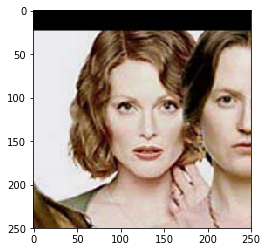

Hello Human!
Resembing dog breed is Poodle


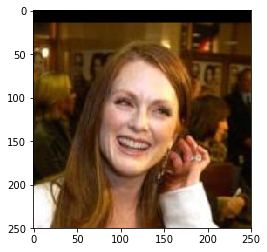

Hello Human!
Resembing dog breed is Mastiff


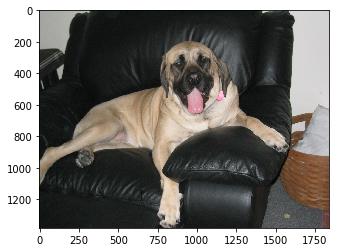

Hello Dog!
Dog breed is Plott


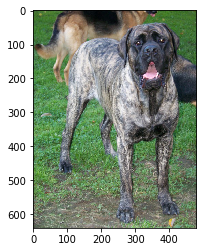

In [59]:

for file in np.hstack((human_files[40:42], dog_files[40:42])):
    run_app(file)

Not Dog, Neither Human!


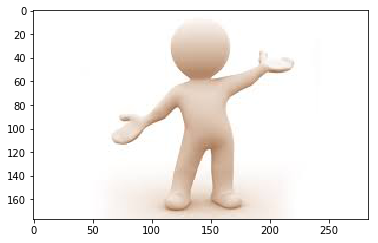

Hello Human!
Resembing dog breed is Afghan hound


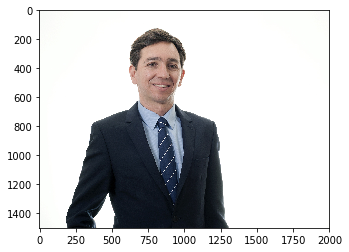

Not Dog, Neither Human!


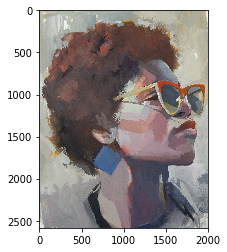

Hello Dog!
Dog breed is Belgian sheepdog


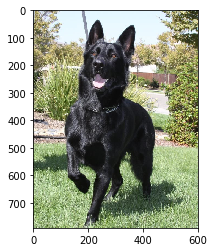

Hello Dog!
Dog breed is Entlebucher mountain dog


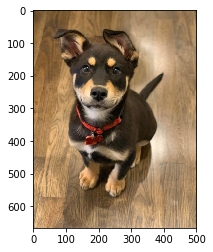

Not Dog, Neither Human!


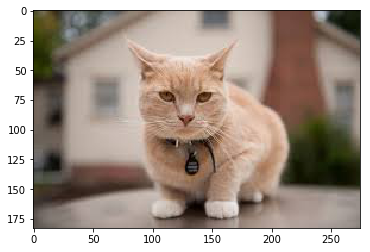

Hello Dog!
Dog breed is Alaskan malamute


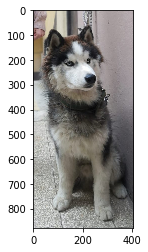

In [64]:
import os
from PIL import Image

for img_file in os.listdir('my_Images'):
    img_path = os.path.join('my_Images', img_file)
    run_app(img_path)
    
    